# Loan Default Prediction and Analysis

## Abstract

Predicting loan defaults is a critical task for financial institutions to manage risk and make informed lending decisions. This project focuses on developing and evaluating various machine learning models to predict loan defaults using historical data. By employing a comprehensive approach involving data cleaning, visualisation, model training, and evaluation, we aim to identify the most effective model for accurate predictions. Additionally, we calculate the expected loss for loans to provide actionable insights for financial risk management.

## Introduction

In the financial industry, predicting loan defaults is crucial for risk management and decision-making processes. This project aims to develop robust machine learning models to predict loan defaults based on historical data. We will undertake a comprehensive approach that includes data loading, cleaning, visualisation, model training, evaluation, and the calculation of expected loss. Our goal is to identify the most effective model for predicting defaults and to provide actionable insights to minimise financial risks.

## Report Breakdown

### 1. Data Loading and Initial Exploration

We start by loading the dataset and performing an initial exploration to understand its structure, check for duplicates, and identify any missing values. This step is crucial to ensure the data is ready for analysis.

### 2. Data Visualisation

We use various visualisation techniques to understand the distribution of the target variable (default) and the features. This includes:
- Bar chart for the default distribution
- Boxplots for each feature to check for outliers
- Histograms to analyse the distribution of features after scaling
- Correlation heatmap to identify relationships between features and the target variable

### 3. Data Cleaning

We clean the data by removing outliers using the IQR method and scale the features using StandardScaler. This ensures that the data is standardised and ready for model training.

### 4. Feature Engineering

We create additional interaction, quadratic, and domain-specific features to enhance the predictive power of the models.

### 5. Model Training, Evaluation, Comparison and Hyperparameter Tuning

We split the data into training and testing sets and train several machine learning models, including:
- Logistic Regression
- Decision Tree
- Random Forest
- Gradient Boosting Machine
- XGBoost

Each model is evaluated based on accuracy, ROC-AUC score, and classification reports. We also visualise the performance using confusion matrices and ROC curves.

We compare the performance of different models using 5-fold cross-validation. For the best-performing model (XGBoost), we perform hyperparameter tuning to further improve its performance.

### 6. Expected Loss Calculation

We calculate the Probability of Default (PD) and expected loss for loans, considering the recovery rate. The expected loss is also converted to the original scale for better interpretation.

### 7. Conclusion

We summarise the findings of the project, highlighting the effectiveness of the tuned XGBoost model and the insights gained from the expected loss analysis. We also discuss potential future work to further enhance the models and their applicability.

---

## 1. Data Loading and Initial Exploration

In [1009]:
# Load required libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import shap

In [1010]:
# Load the data
file_path = 'Task 3 and 4_Loan_Data.csv'
loan_data = pd.read_csv(file_path)

In [1011]:
# Initial data exploration
loan_data.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [1012]:
print(f"Number of duplicated rows: {loan_data.duplicated().sum()}")

Number of duplicated rows: 0


In [1013]:
loan_data.isnull().sum()

customer_id                 0
credit_lines_outstanding    0
loan_amt_outstanding        0
total_debt_outstanding      0
income                      0
years_employed              0
fico_score                  0
default                     0
dtype: int64

In [1014]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   credit_lines_outstanding  10000 non-null  int64  
 2   loan_amt_outstanding      10000 non-null  float64
 3   total_debt_outstanding    10000 non-null  float64
 4   income                    10000 non-null  float64
 5   years_employed            10000 non-null  int64  
 6   fico_score                10000 non-null  int64  
 7   default                   10000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 625.1 KB


In [1015]:
loan_data.shape

(10000, 8)

## 2. Data Visualisation

### 2.1 Default Distribution

In [1017]:
# Visualisation settings
sns.set(style='whitegrid')

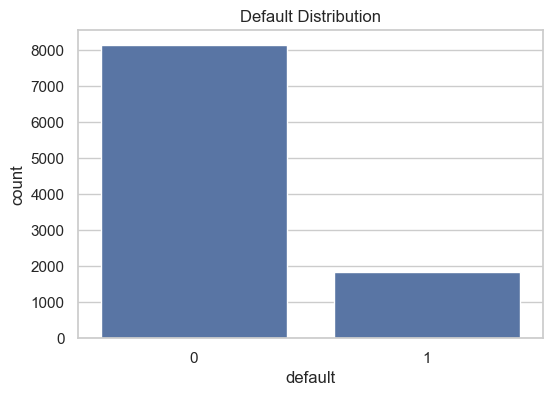

In [1018]:
# Bar chart for default distribution
plt.figure(figsize = (6, 4))
sns.countplot(x = 'default', data = loan_data)
plt.title('Default Distribution')
plt.show()

2.2 Boxplots for Features

In [1020]:
# Dropping irrelevant columns
features = loan_data.drop(['customer_id', 'default'], axis=1).columns.tolist()

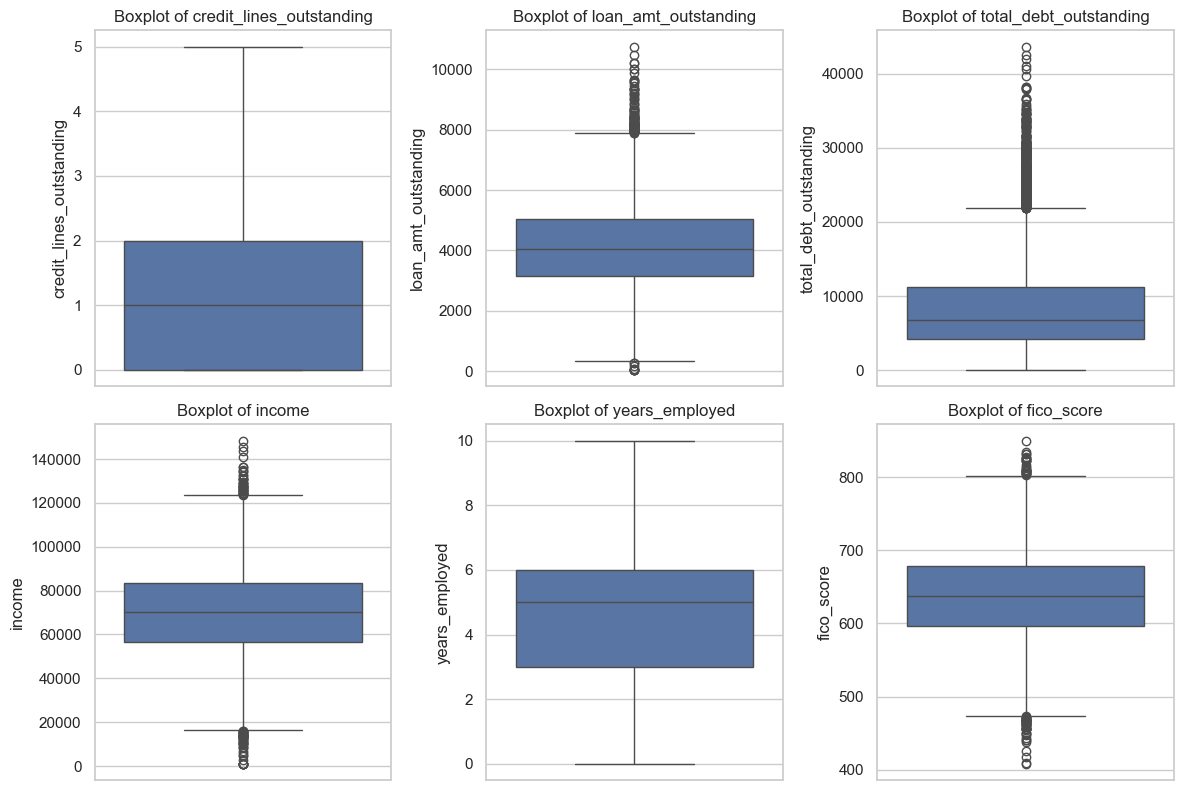

In [1021]:
# Create a figure for the boxplots
plt.figure(figsize=(12, 12))

# Generate boxplots for each feature
for idx, col in enumerate(features):
    plt.subplot(3, 3, idx + 1)
    sns.boxplot(y=loan_data[col])
    plt.title(f'Boxplot of {col}')

# Adjust the layout
plt.tight_layout()
plt.show()

## 3. Data Cleaning

### 3.1 Removing Outliers using IQR Method

In [1023]:
# Function to remove outliers using IQR method
def remove_outliers(df, features):
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    return df

In [1024]:
# Remove all outliers from the data 
loan_data_cleaned = remove_outliers(loan_data, features)

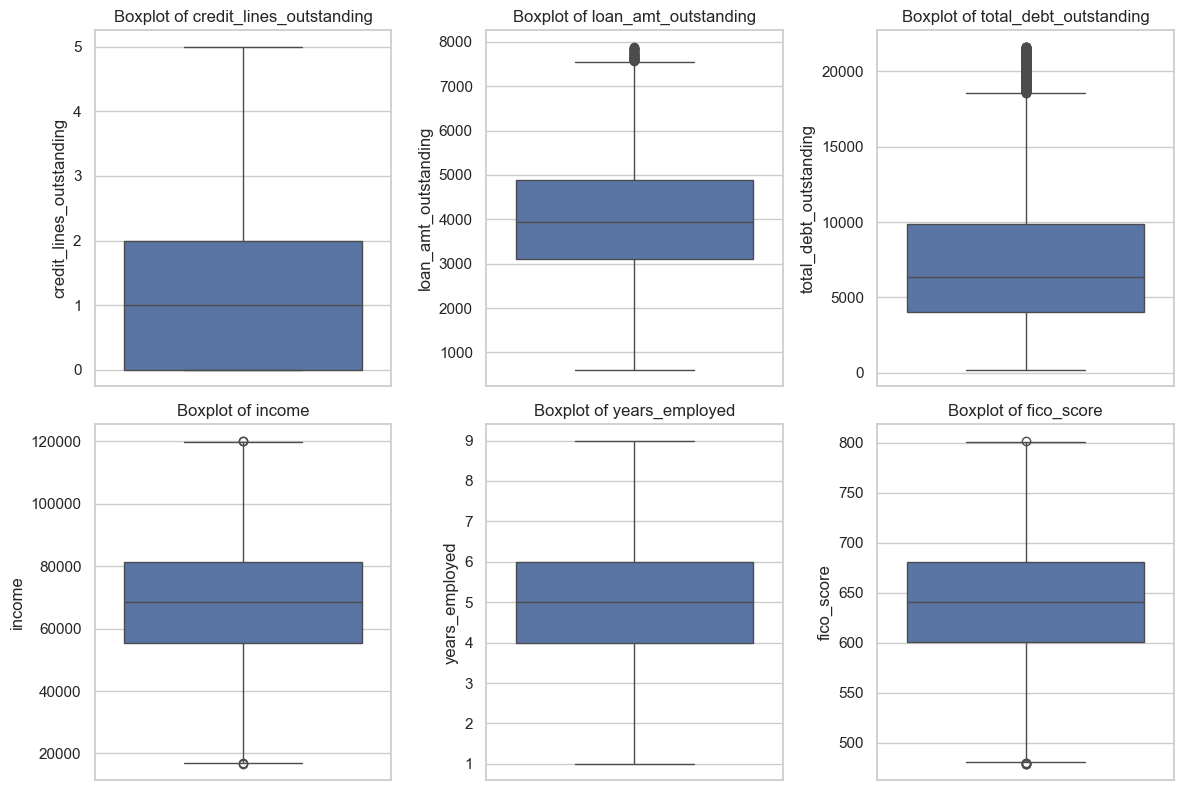

In [1025]:
# Create a figure for the boxplots after outlier removal
plt.figure(figsize=(12, 12))

# Generate boxplots for each feature
for idx, col in enumerate(features):
    plt.subplot(3, 3, idx + 1)
    sns.boxplot(y=loan_data_cleaned[col])
    plt.title(f'Boxplot of {col}')

# Adjust the layout
plt.tight_layout()
plt.show()

### 3.2 Distribution of Features After Scaling

In [1027]:
# Initialise the StandardScaler
scaler = StandardScaler()

# Apply scaling
loan_data_cleaned[features] = scaler.fit_transform(loan_data_cleaned[features])

# Display the first few rows of the updated DataFrame
loan_data_cleaned.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,-0.791768,0.917001,-0.739763,0.512571,0.241525,-0.610732,0
1,7442532,2.434267,-1.605118,0.147443,-2.238095,-1.720051,-1.178625,1
2,2256073,-0.791768,-0.519714,-1.128035,-0.138963,-0.412334,-0.662359,0
3,4885975,-0.791768,0.565350,-1.030558,0.315467,0.241525,-0.490270,0
4,4700614,-0.146561,-2.079068,-1.181310,-2.409379,0.895384,-0.163301,0


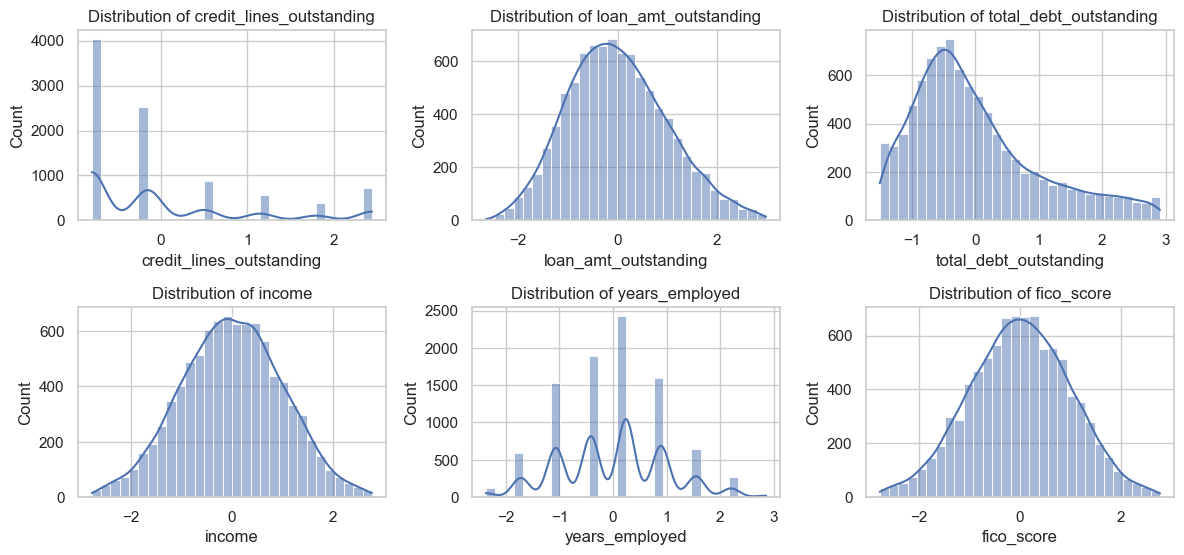

In [1028]:
# Create a figure for the histograms
plt.figure(figsize=(12, 8))

# Generate histograms for each feature
for idx, feature in enumerate(features, 1):
    plt.subplot(3, 3, idx)
    sns.histplot(loan_data_cleaned[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature}')

# Adjust the layout
plt.tight_layout()
plt.show()

### 3.3 Correlation Heatmap

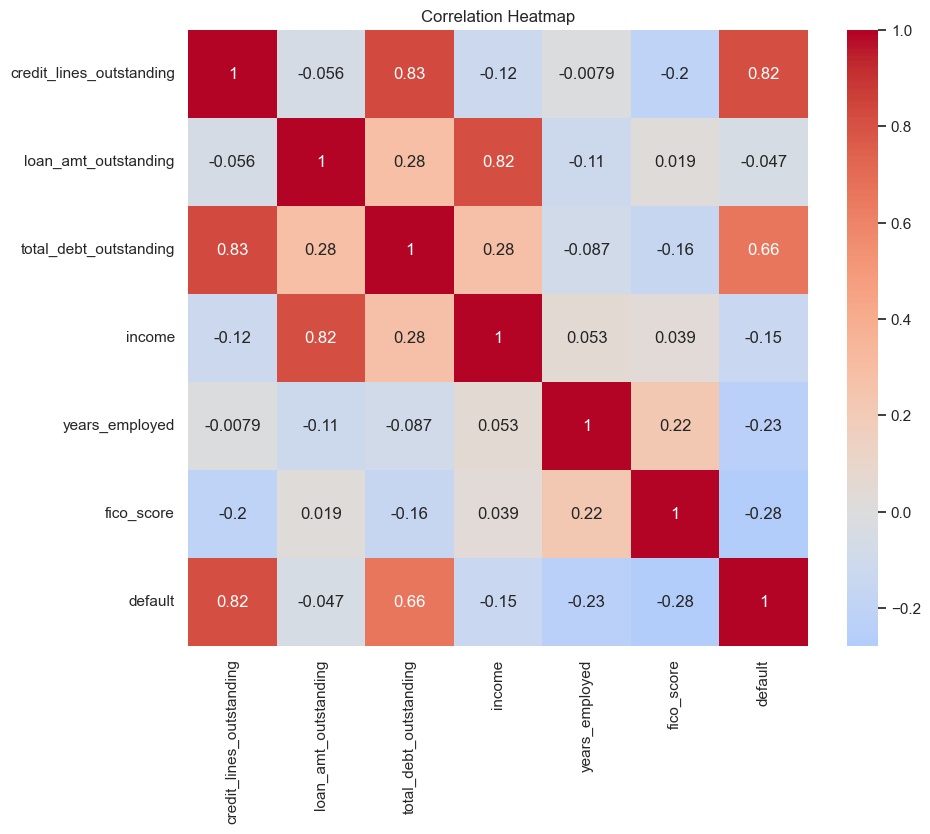

(9126, 8)

In [1030]:
# Calculate the correlation matrix
correlation_matrix = loan_data_cleaned[features + ['default']].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

loan_data_cleaned.shape

## 4. Feature Engineering

### 4.1 Create New Features

In [1032]:
# Create a duplicated dataframe for feature engineering
loan_data_features = loan_data_cleaned.copy()

# Create interaction features
loan_data_features['credit_lines_outstanding_total_debt'] = loan_data_features['credit_lines_outstanding'] * loan_data_features['total_debt_outstanding']
loan_data_features['credit_lines_outstanding_income'] = loan_data_features['credit_lines_outstanding'] * loan_data_features['income']
loan_data_features['total_debt_income'] = loan_data_features['total_debt_outstanding'] * loan_data_features['income']

# Create quadratic features
loan_data_features['credit_lines_outstanding_squared'] = loan_data_features['credit_lines_outstanding'] ** 2
loan_data_features['total_debt_outstanding_squared'] = loan_data_features['total_debt_outstanding'] ** 2
loan_data_features['income_squared'] = loan_data_features['income'] ** 2

# Replace negative values with NaN for log transformation
loan_data_features['credit_lines_outstanding'] = loan_data_features['credit_lines_outstanding'].apply(lambda x: np.nan if x < 0 else x)
loan_data_features['total_debt_outstanding'] = loan_data_features['total_debt_outstanding'].apply(lambda x: np.nan if x < 0 else x)
loan_data_features['income'] = loan_data_features['income'].apply(lambda x: np.nan if x < 0 else x)

# Create log features (log1p handles zero values correctly)
loan_data_features['log_credit_lines_outstanding'] = np.log1p(loan_data_features['credit_lines_outstanding'])
loan_data_features['log_total_debt_outstanding'] = np.log1p(loan_data_features['total_debt_outstanding'])
loan_data_features['log_income'] = np.log1p(loan_data_features['income'])

# Create new domain knowledge features
loan_data_features['debt_to_income_ratio'] = loan_data_features['total_debt_outstanding'] / loan_data_features['income']
loan_data_features['credit_usage'] = loan_data_features['loan_amt_outstanding'] / loan_data_features['total_debt_outstanding']
loan_data_features['employment_income_ratio'] = loan_data_features['years_employed'] / loan_data_features['income']

# Drop any remaining NaN values in the duplicated dataframe
loan_data_features = loan_data_features.dropna()

loan_data_features.head()


,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default,credit_lines_outstanding_total_debt,credit_lines_outstanding_income,total_debt_income,credit_lines_outstanding_squared,total_debt_outstanding_squared,income_squared,log_credit_lines_outstanding,log_total_debt_outstanding,log_income,debt_to_income_ratio,credit_usage,employment_income_ratio
10,1946105,2.434267,0.146282,2.333850,0.455602,1.549243,-0.008422,1,5.681213,1.109057,1.063306,5.925656,5.446855,0.207573,1.233804,1.204128,0.375419,5.122564,0.062679,3.400431
20,2723215,0.498646,-0.431259,0.180422,0.122981,2.203101,0.456218,0,0.089967,0.061324,0.022188,0.248648,0.032552,0.015124,0.404562,0.165872,0.115987,1.467071,-2.390286,17.914182
32,6325220,2.434267,-0.407706,2.566819,0.054794,-0.412334,-1.694891,1,6.248324,0.133383,0.140646,5.925656,6.588562,0.003002,1.233804,1.271674,0.053346,46.844833,-0.158837,-7.525151
33,6037431,1.143853,1.153859,1.498104,0.521744,-0.412334,0.473427,0,1.713611,0.596798,0.781626,1.308400,2.244315,0.272216,0.762605,0.915532,0.419857,2.871341,0.770213,-0.790300
41,6645305,0.498646,-0.648534,0.981869,1.264385,1.549243,1.815719,0,0.489605,0.630481,1.241461,0.248648,0.964067,1.598671,0.404562,0.684040,0.817303,0.776558,-0.660509,1.225293


In [1033]:
# Dropping irrelevant columns
features = loan_data_features.drop(['customer_id', 'default'], axis=1).columns.tolist()

# Dropping all NaN values
loan_data_features = loan_data_features.dropna()

### 4.2 Correlation Heatmap

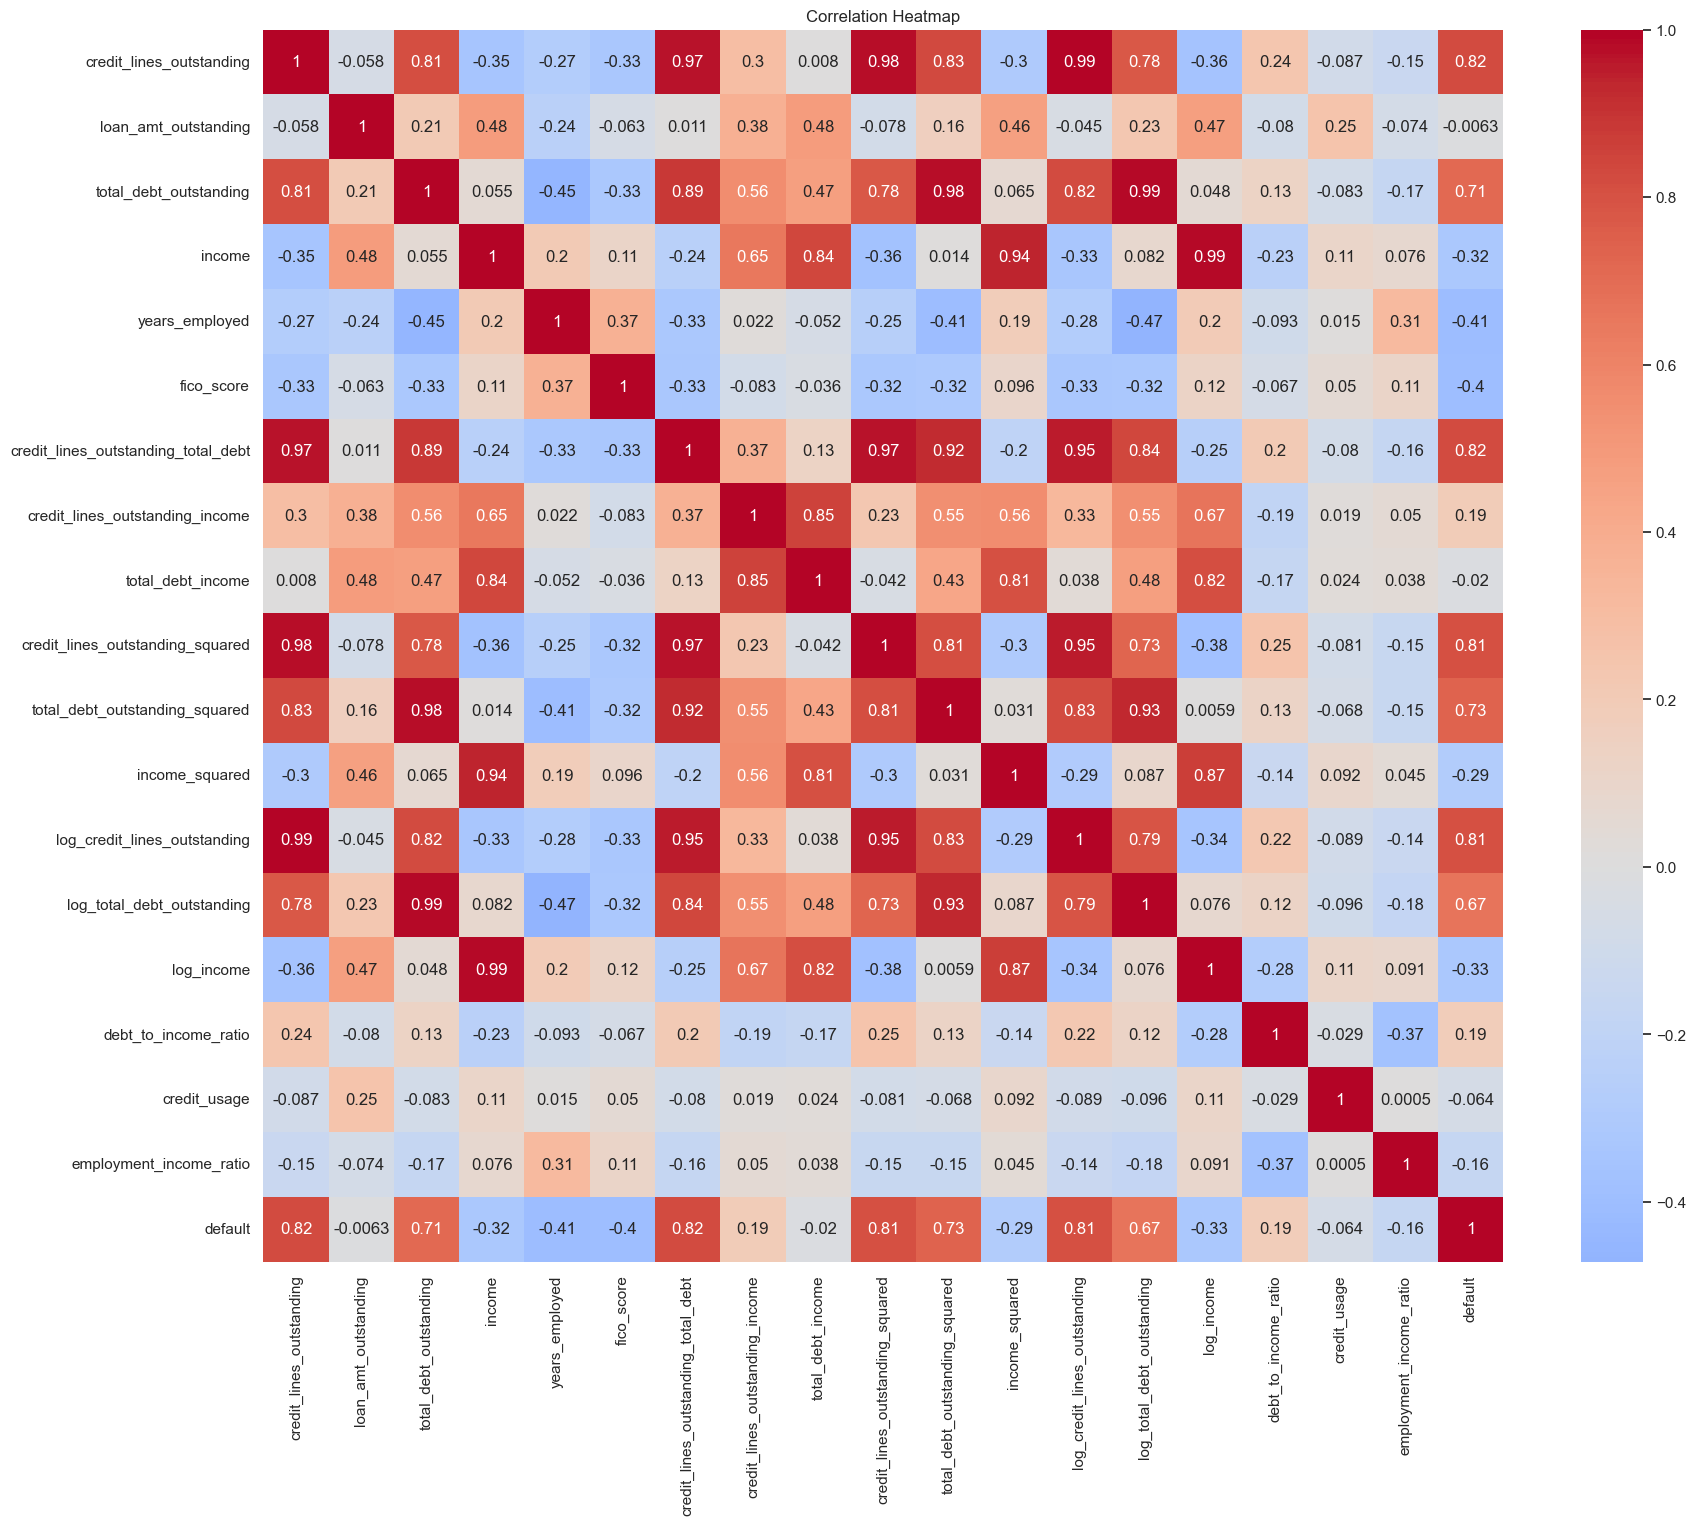

In [1035]:
# Calculate the correlation matrix
correlation_matrix = loan_data_features[features + ['default']].corr()

# Create a heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

After creating these new features, we evaluated their impact on the dataset and model performance. The reasons for not using the additional features are as follows:

1. **Reduction in Dataset Size**: 
   - After creating the new features and performing necessary data cleaning steps (such as handling NaN values resulting from log transformations), the number of records in our dataset dropped significantly from around 9,126 to approximately 667.
   - This significant reduction in dataset size can lead to overfitting, where the model performs well on the training data but poorly on unseen data.

2. **Increased Complexity**: 
   - Introducing a large number of additional features increases the complexity of the model.
   - High model complexity can lead to longer training times and more difficulty in interpreting the model's behaviour.

3. **Model Performance**:
   - Despite the addition of new features, there was no significant improvement in model performance metrics such as accuracy, ROC-AUC, and F1-score.
   - Adding more features did not provide additional predictive power, suggesting that the original features were already capturing the necessary information for predicting loan defaults.

Given these factors, we decided to retain the original set of features for model training and evaluation. This approach ensures a balance between model simplicity and performance while maintaining a sufficient number of records for robust training and testing.

## 5. Model Training and Evaluation

### 5.1 Data Splitting

In [1038]:
# Define features and target variable
X = loan_data_cleaned.drop(columns=['default', 'customer_id'])
y = loan_data_cleaned['default']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 5.2 Logistic Regression

Logistic Regression
Accuracy: 0.9970781592403214
ROC-AUC: 0.9999880934237598
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2386
           1       1.00      0.98      0.99       352

    accuracy                           1.00      2738
   macro avg       1.00      0.99      0.99      2738
weighted avg       1.00      1.00      1.00      2738



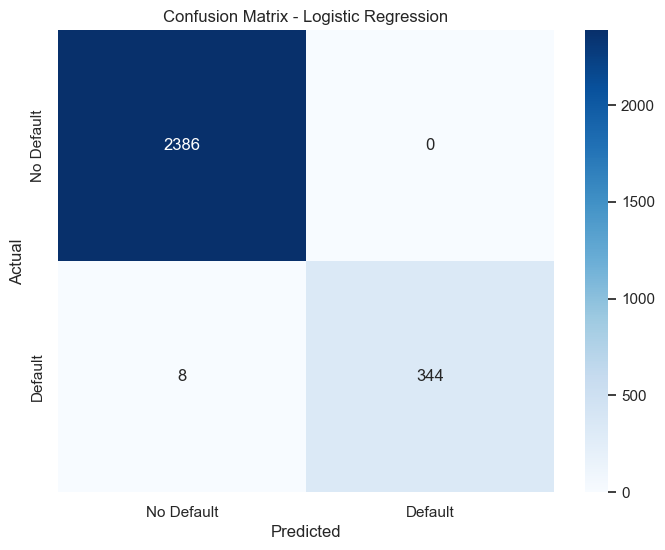

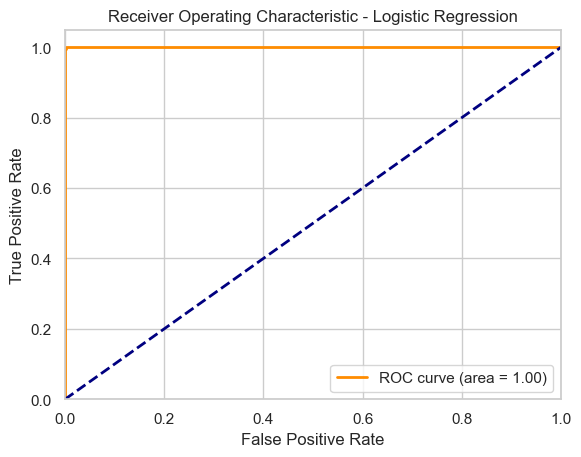

In [1040]:
# Train a logistic regression model
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

# Make predictions
y_pred_log = log_model.predict(X_test)
y_pred_prob_log = log_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob_log))
print("Classification Report:\n", classification_report(y_test, y_pred_log))

# Confusion Matrix
conf_matrix_log = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_log, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_log)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

### 5.3 Decision Tree

Decision Tree
Accuracy: 0.9952520087655223
ROC-AUC: 0.9887994837308542
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2386
           1       0.98      0.98      0.98       352

    accuracy                           1.00      2738
   macro avg       0.99      0.99      0.99      2738
weighted avg       1.00      1.00      1.00      2738



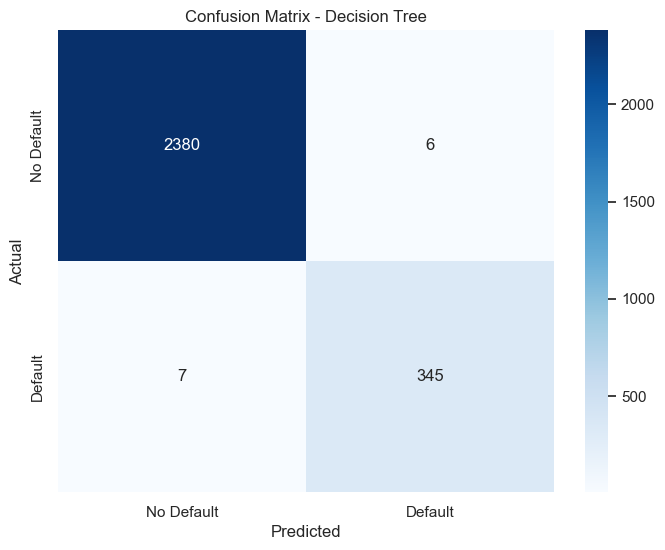

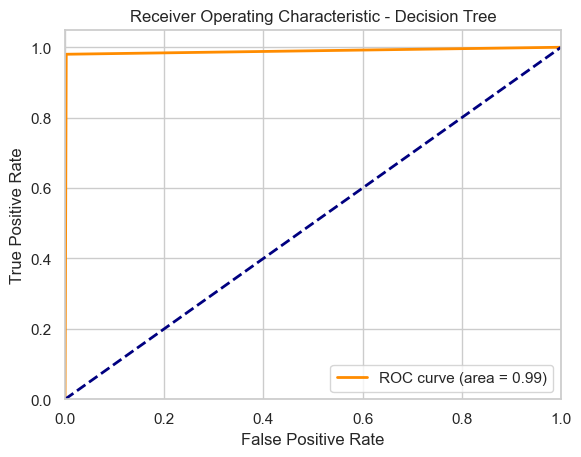

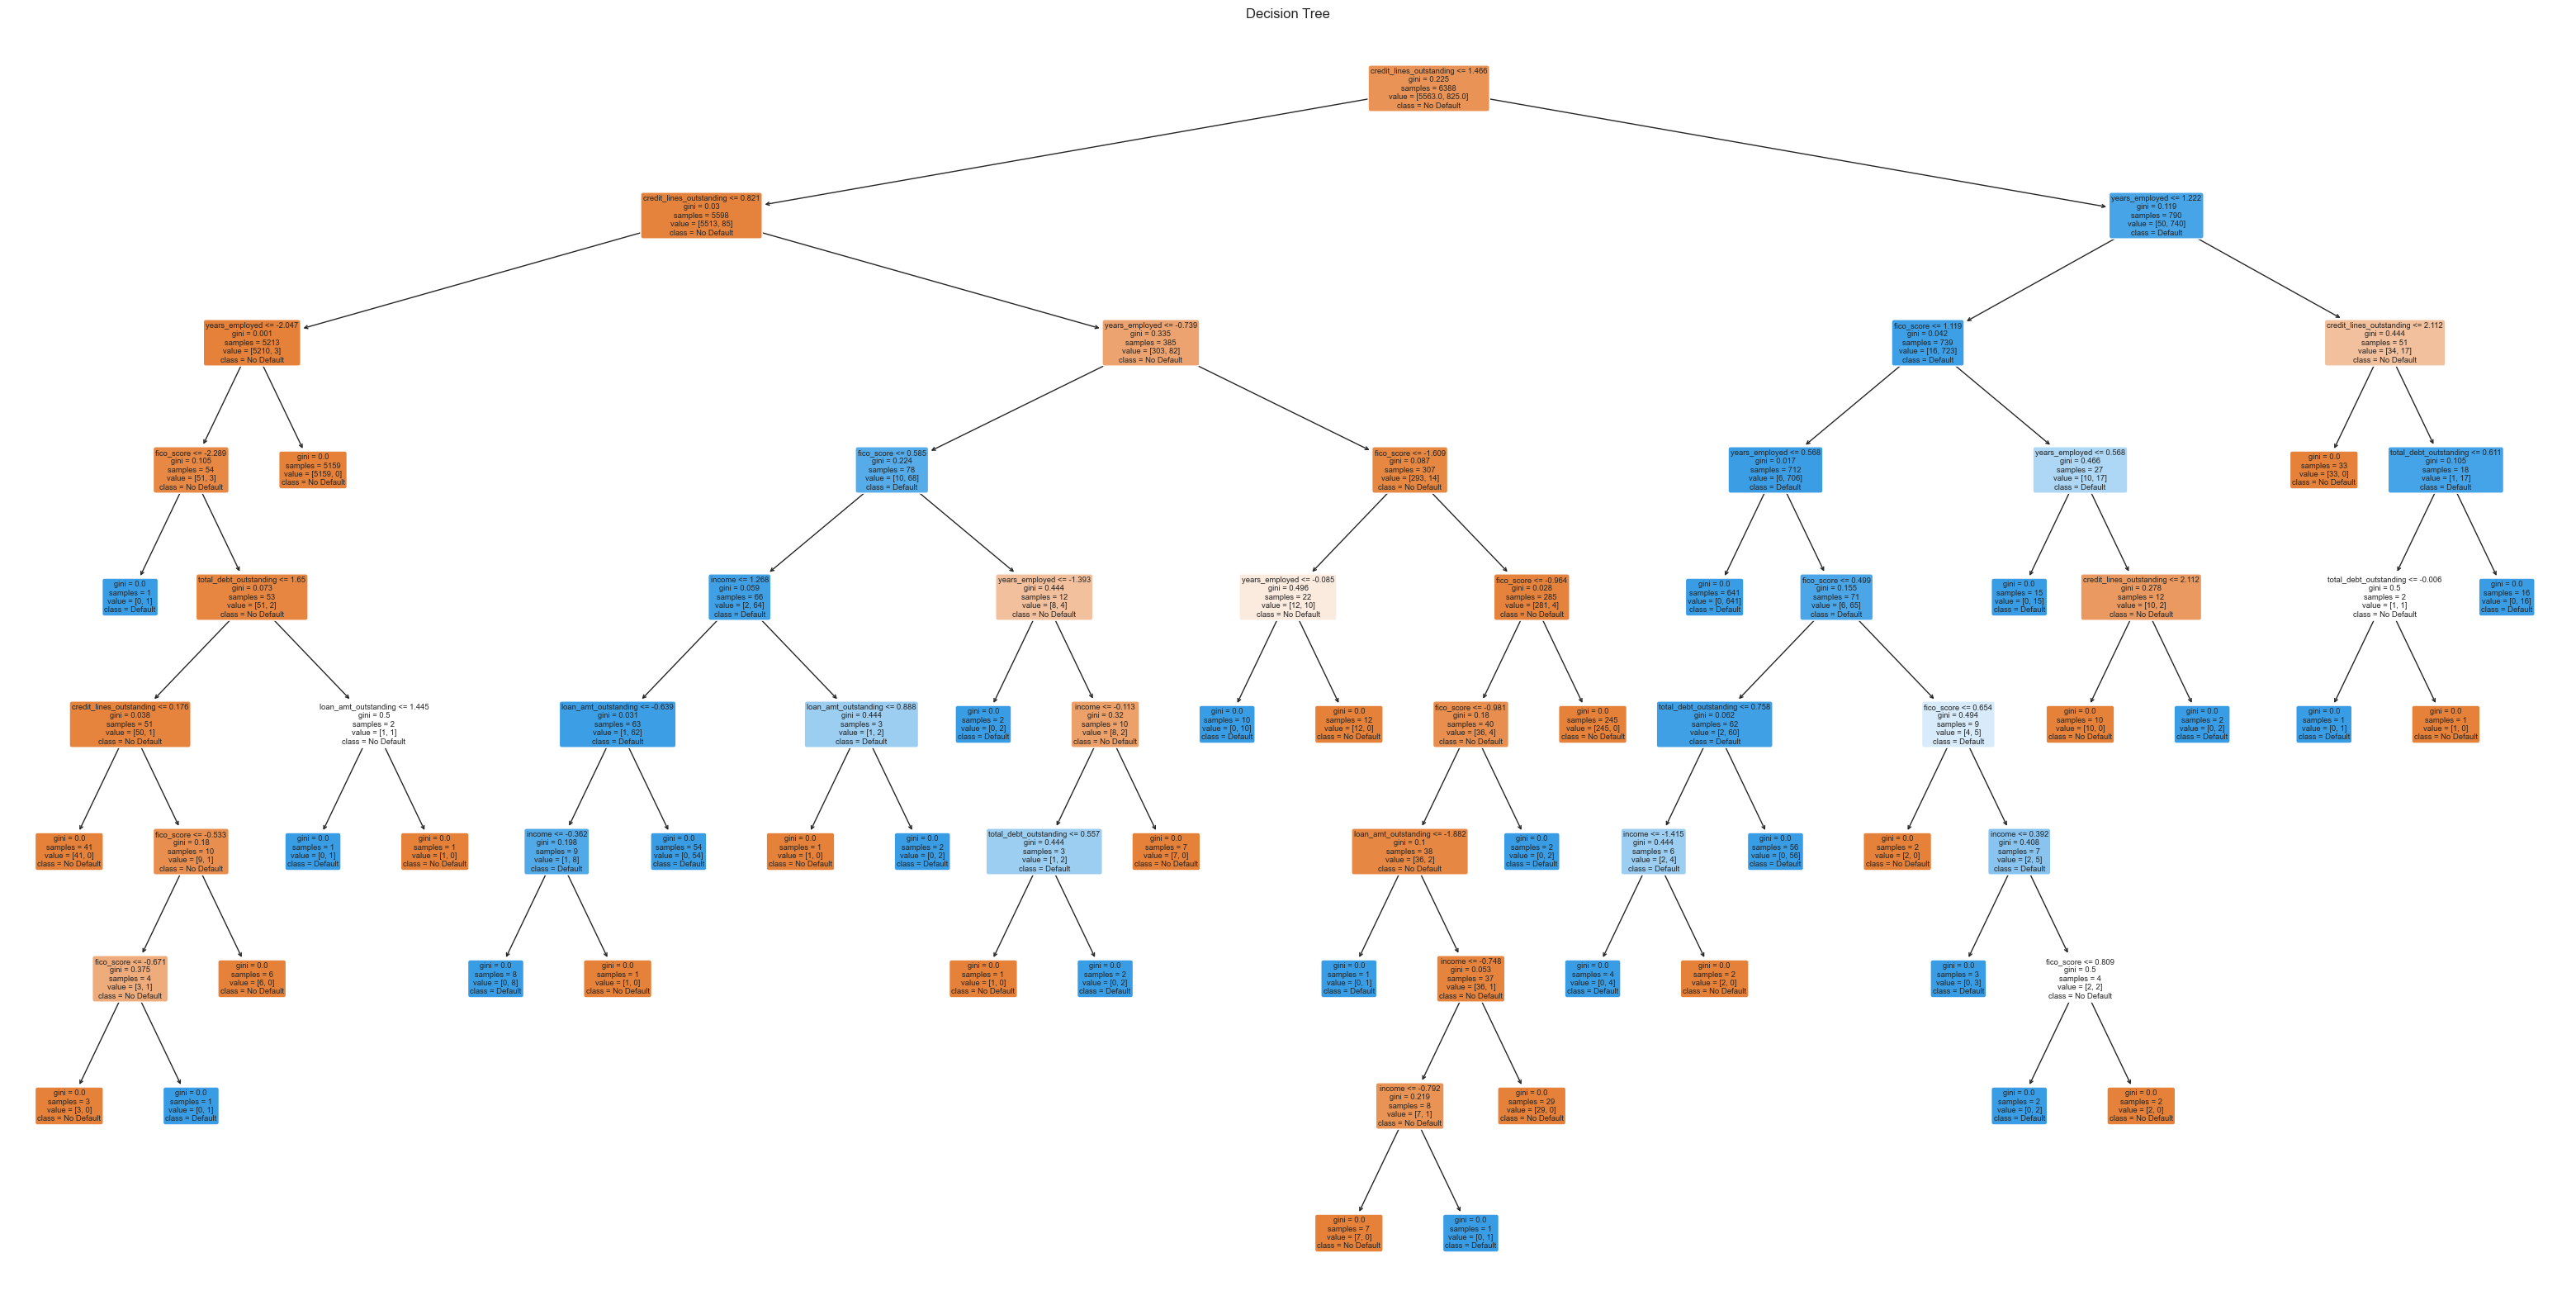

In [1042]:
from sklearn.tree import DecisionTreeClassifier

# Train a decision tree model
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# Make predictionsa
y_pred_tree = tree_model.predict(X_test)
y_pred_prob_tree = tree_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Decision Tree")
print("Accuracy:", accuracy_score(y_test, y_pred_tree))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob_tree))
print("Classification Report:\n", classification_report(y_test, y_pred_tree))

# Confusion Matrix
conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_tree, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_tree)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Decision Tree')
plt.legend(loc="lower right")
plt.show()

# Decision Tree Plot
plt.figure(figsize=(40, 20))
plot_tree(tree_model, filled=True, feature_names=X.columns, class_names=['No Default', 'Default'], rounded=True)
plt.title('Decision Tree')
plt.show()

### 5.4 Random Forest

Random Forest
Accuracy: 0.9948867786705624
ROC-AUC: 0.9996761411262669
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2386
           1       0.99      0.97      0.98       352

    accuracy                           0.99      2738
   macro avg       0.99      0.98      0.99      2738
weighted avg       0.99      0.99      0.99      2738



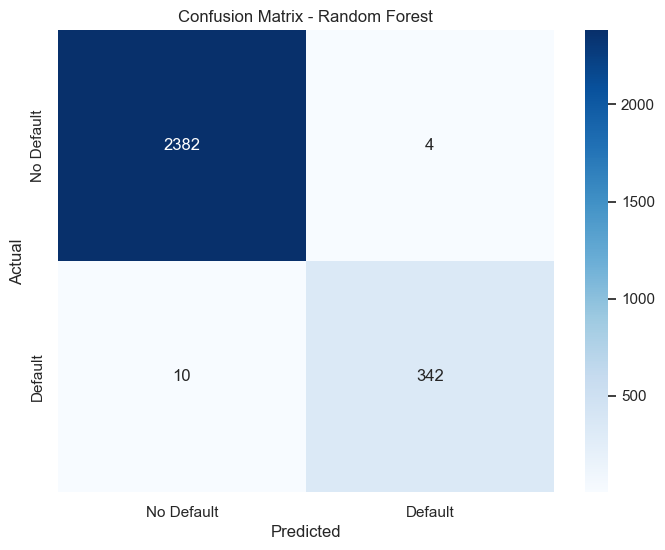

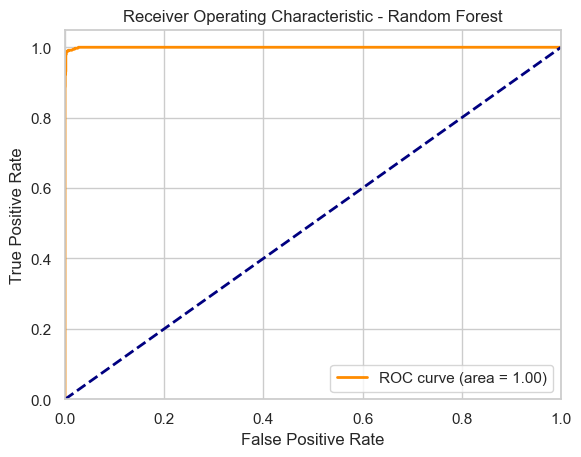

In [1044]:
from sklearn.ensemble import RandomForestClassifier

# Train a random forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# Confusion Matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_rf)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Random Forest')
plt.legend(loc="lower right")
plt.show()

### 5.5 Gradient Boosting Machine

Gradient Boosting Machine
Accuracy: 0.9952520087655223
ROC-AUC: 0.9997672264345042
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2386
           1       0.98      0.98      0.98       352

    accuracy                           1.00      2738
   macro avg       0.99      0.99      0.99      2738
weighted avg       1.00      1.00      1.00      2738



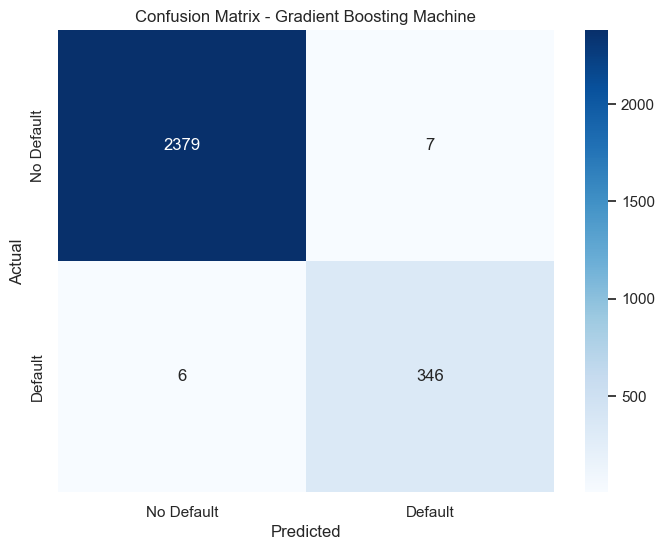

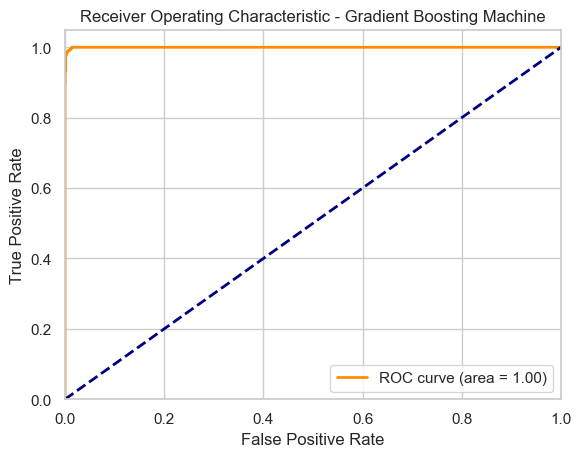

In [1046]:
from sklearn.ensemble import GradientBoostingClassifier

# Train a GBM model
gbm_model = GradientBoostingClassifier(random_state=42)
gbm_model.fit(X_train, y_train)

# Make predictions
y_pred_gbm = gbm_model.predict(X_test)
y_pred_prob_gbm = gbm_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Gradient Boosting Machine")
print("Accuracy:", accuracy_score(y_test, y_pred_gbm))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob_gbm))
print("Classification Report:\n", classification_report(y_test, y_pred_gbm))

# Confusion Matrix
conf_matrix_gbm = confusion_matrix(y_test, y_pred_gbm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gbm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.title('Confusion Matrix - Gradient Boosting Machine')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_gbm)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Gradient Boosting Machine')
plt.legend(loc="lower right")
plt.show()

### 5.6 XGBoost

XGBoost
Accuracy: 0.9948867786705624
ROC-AUC: 0.9998475958241255
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2386
           1       0.98      0.98      0.98       352

    accuracy                           0.99      2738
   macro avg       0.99      0.99      0.99      2738
weighted avg       0.99      0.99      0.99      2738



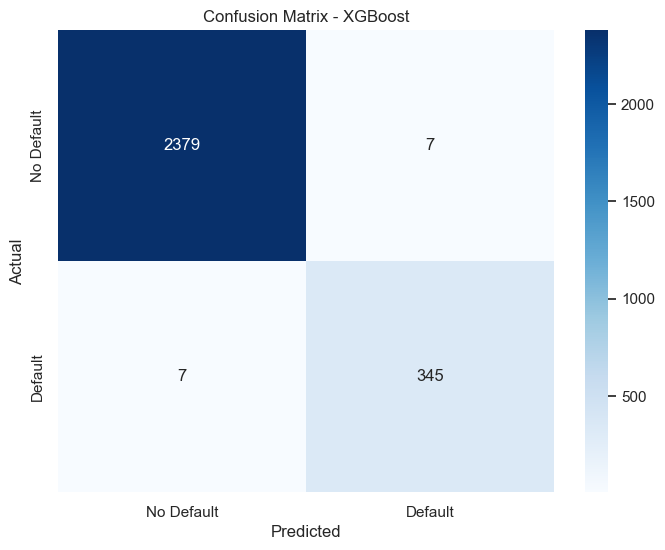

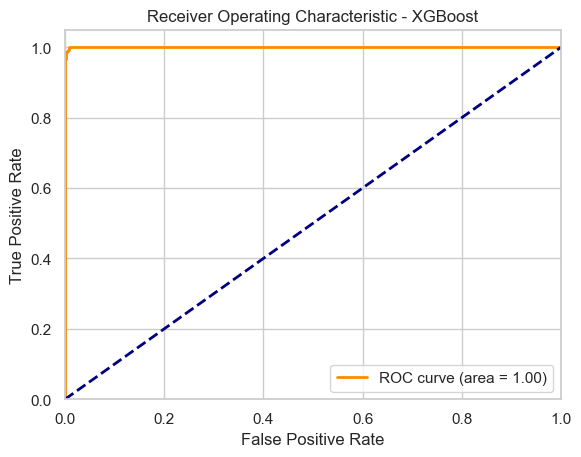

In [1048]:
# Train an XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("XGBoost")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

# Confusion Matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_xgb)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - XGBoost')
plt.legend(loc="lower right")
plt.show()

### 5.7 Model Comparison

In [ ]:
from sklearn.model_selection import cross_val_score

# Define a list of models to evaluate
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting Machine': GradientBoostingClassifier(random_state=42),
    'XGBoost model' : xgb.XGBClassifier(random_state=42)
}

# Perform 5-fold cross-validation for each model
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    print(f"{model_name} - Mean ROC-AUC: {cv_scores.mean()}, Std: {cv_scores.std()}")

Logistic Regression - Mean ROC-AUC: 0.9999903879956544, Std: 1.0341684400796286e-05
Decision Tree - Mean ROC-AUC: 0.9910949481242912, Std: 0.004832211817020156
Random Forest - Mean ROC-AUC: 0.9997623963325569, Std: 0.00011266015213687987


### 5.8 Hyperparameter Tuning for XGBoost

In [ ]:
# Hyperparameter Tuning for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 5, 7, 10],
    'colsample_bytree': [0.3, 0.5, 0.7, 1.0],
    'subsample': [0.3, 0.5, 0.7, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0]
}
random_search_xgb = RandomizedSearchCV(estimator=xgb.XGBClassifier(random_state=42), param_distributions=param_grid_xgb, n_iter=50, cv=5, scoring='roc_auc', n_jobs=-1, random_state=42)
random_search_xgb.fit(X_train, y_train)
print("Best Parameters for XGBoost:", random_search_xgb.best_params_)
print("Best ROC-AUC for XGBoost:", random_search_xgb.best_score_)

### 5.9 Tuned XGBoost Evaluation

In [ ]:
# Evaluate the Tuned XGBoost Model
best_xgb_model = random_search_xgb.best_estimator_
y_pred_best_xgb = best_xgb_model.predict(X_test)
y_pred_prob_best_xgb = best_xgb_model.predict_proba(X_test)[:, 1]
print("Tuned XGBoost")
print("Accuracy:", accuracy_score(y_test, y_pred_best_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob_best_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_best_xgb))
conf_matrix_best_xgb = confusion_matrix(y_test, y_pred_best_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_best_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.title('Confusion Matrix - Tuned XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_best_xgb)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Tuned XGBoost')
plt.legend(loc="lower right")
plt.show()

### 5.10 Learning Curve for Tuned XGBoost

In [ ]:
# Learning Curve
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    return plt

# Plot learning curve for the best model
plot_learning_curve(best_xgb_model, "Learning Curve - XGBoost", X, y, cv=5)
plt.show()

### 5.11 Precision-Recall Curve for Tuned XGBoost

In [ ]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob_best_xgb)
plt.figure()
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - XGBoost')
plt.show()

### 5.12 Feature Importance for Tuned XGBoost

In [ ]:
# Feature Importance for XGBoost
importances = best_xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances - XGBoost")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

### 5.13 SHAP Values for Tuned XGBoost

In [ ]:
# SHAP values for XGBoost
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

## 6. Expected Loss Calculation

### 6.1 Probability of Default and Expected Loss

In [ ]:
# Predict Probability of Default (PD)
probability_of_default = best_xgb_model.predict_proba(X_test)[:, 1]
X_test_with_prob = X_test.copy()
X_test_with_prob['Probability of Default'] = probability_of_default
X_test_with_prob.head()

In [ ]:
# Calculate Expected Loss
loan_amount = X_test_with_prob['loan_amt_outstanding']
recovery_rate = 0.10
expected_loss = loan_amount * probability_of_default * (1 - recovery_rate)
X_test_with_prob['Expected Loss'] = expected_loss
X_test_with_prob[['loan_amt_outstanding', 'Probability of Default', 'Expected Loss']].head()

### 6.2 Convert Expected Loss to Original Scale

In [ ]:
# Assuming df is the original dataframe and df_cleaned is the scaled dataframe
loan_amt_mean = loan_data['loan_amt_outstanding'].mean()
loan_amt_std = loan_data['loan_amt_outstanding'].std()

# Calculate Expected Loss (as previously done)
loan_amount = X_test_with_prob['loan_amt_outstanding']
recovery_rate = 0.10
expected_loss = loan_amount * probability_of_default * (1 - recovery_rate)
X_test_with_prob['Expected Loss'] = expected_loss

# Convert Expected Loss to Original Scale
expected_loss_original = (X_test_with_prob['Expected Loss'] * loan_amt_std) + loan_amt_mean
X_test_with_prob['Expected Loss Original'] = expected_loss_original

total_expected_loss = X_test_with_prob['Expected Loss Original'].sum()

# Print the total expected loss
print(f"Total Expected Loss (Original Scale): {total_expected_loss:.2f}")

# Display the first few rows with the original expected loss
X_test_with_prob[['loan_amt_outstanding', 'Probability of Default', 'Expected Loss', 'Expected Loss Original']].head()

### 6.3 Histogram of Expected Loss

In [ ]:
# Histogram of Expected Loss
plt.figure(figsize=(10, 6))
sns.histplot(X_test_with_prob['Expected Loss Original'], bins=30, kde=True)
plt.title('Distribution of Expected Loss')
plt.xlabel('Expected Loss')
plt.ylabel('Frequency')
plt.show()

## 7. Conclusion

In this project, we conducted an in-depth analysis to predict loan defaults using various machine learning models. We began by loading and cleaning the data to ensure accuracy and reliability. Through extensive visualisation, we gained insights into the data distribution and relationships between features.

We trained and evaluated multiple models including Logistic Regression, Decision Tree, Random Forest, Gradient Boosting Machine, and XGBoost. Our findings indicated that the tuned XGBoost model outperformed other models in terms of accuracy and ROC-AUC score.

Additionally, we calculated the expected loss for loans to assess potential financial risks. The comprehensive analysis provided a clear understanding of the key factors influencing loan defaults, enabling better risk management.

This project highlights the importance of data-driven approaches in financial decision-making and showcases the effectiveness of advanced machine learning techniques in predictive analytics. Future work could explore further feature engineering, alternative modelling techniques, and real-time prediction systems to enhance the robustness and applicability of the models.
